# Machine Learning Notebook

In [42]:
import pandas as pd

import matplotlib.pyplot as plt

import os

In [8]:
os.getcwd()

'\\\\ganymede\\data_science\\ad-frazier\\data_science\\ggu\\summer_22\\msba_326\\326_final_project\\notebooks'

In [9]:
#os.chdir('/home/ad-frazier/data_science/ggu/summer_22/msba_326/326_final_project/')

In [10]:
df = pd.read_pickle('../data/df_cleaned.pkl')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   administrative           12330 non-null  int32   
 1   administrative_duration  12330 non-null  float64 
 2   informational            12330 non-null  int32   
 3   informational_duration   12330 non-null  float64 
 4   productrelated           12330 non-null  int32   
 5   productrelated_duration  12330 non-null  float64 
 6   bouncerates              12330 non-null  float64 
 7   exitrates                12330 non-null  float64 
 8   pagevalues               12330 non-null  float64 
 9   specialday               12330 non-null  float64 
 10  month                    12330 non-null  category
 11  operatingsystems         12330 non-null  category
 12  browser                  12330 non-null  category
 13  region                   12330 non-null  category
 14  traffi

**First 5 Features represent the number of different types of pages visited by the visitor in that session and total time spent in each of these page categories.**

In [12]:
df.revenue.value_counts()

False    10422
True      1908
Name: revenue, dtype: int64

We note a slight class inbalance of 1:5 true vs false. 

### Data preparation for ML input
* One-Hot Encode Categorical Values
* Normlize Numeric Values
* Consider Target Class Imbalance effect on model performance. 

* Pipelines Tutorial: https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf

In [13]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier

In [14]:
# encode target variable
df.revenue = df.revenue.cat.codes

In [15]:
# define input and target variables
X = df.drop(columns=['revenue'])
y = df['revenue']

# split input/target into train/test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
# Verify shape of input and target
print(X.shape)
print(y.shape)

(12330, 17)
(12330,)


In [17]:
# create numeric pre-processing step
numeric_transformer = Pipeline(steps=[
                                ('scaler', StandardScaler())
                                    ])
    
# create One Hot Encoder step for categorical 
categorical_transformer = Pipeline(steps=[
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                        ])

In [18]:
# select all numeric features except for target column
numeric_features = df.select_dtypes(include=['number']).drop(columns='revenue').columns

# Select all categorical features
categorical_features = df.select_dtypes(include=['category']).columns

# create pre-processor pipeline containing numeric and categorical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
                ])

### Run Baseline evaluation with RandomForestClassifier

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [19]:
# instantiate model with pipeline steps
rf = Pipeline(steps=[
                    ('preprocessor', preprocessor),
                    ('classifier', RandomForestClassifier())
                    ])

# Fit model with pipeline steps to training data
rf.fit(X_train, y_train);

# Make predictions
y_pred = rf.predict(X_test)

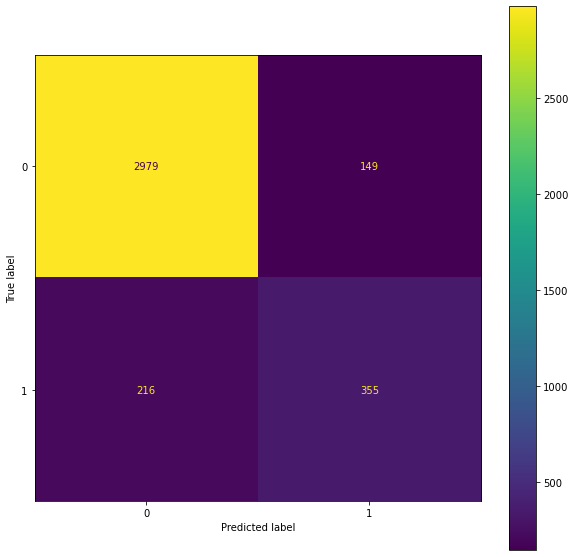

In [50]:
# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf.classes_)
disp.plot()

fig = disp.ax_.get_figure() 
fig.set_figwidth(10)
fig.set_figheight(10)  

In [51]:
# get classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3128
           1       0.70      0.62      0.66       571

    accuracy                           0.90      3699
   macro avg       0.82      0.79      0.80      3699
weighted avg       0.90      0.90      0.90      3699



#### Baseline Summary: 

As we can see, the imbalanced target class requires some refinement in order to hopefully improve model performance. Scoring of the dominant class, no revenue, is very good due to how many instances it contains - scoring of the minority class, revenue generated, is poor because there are so few instances of it to train the model on. 
  

Next, we evaluate the effectivess of class rebalancing using SMOTE. 

### Class re-balance
* https://machinelearningmastery.com/what-is-imbalanced-classification/  
* https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
* https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [23]:
print(X.shape)
print(y.shape)

(12330, 17)
(12330,)


In [24]:
# re-confirm class imbalance
y.value_counts()

0    10422
1     1908
Name: revenue, dtype: int64

**Note the high level of class imbalance - a ratio of about 1:5 1 vs 0 (where 1 indicates revenue generated, and 0 indicates no revenue generated)**

Note: previous notebook iteration applied SMOTE to all features (X, y) instead of only training features (X_train, y_train).  
This technique was incorrect and can lead to data leakage in the model as well as occurrences of synthetic samples in the test set which can adversely affect model evaluation metrics(introducing incorrect biases)  
The code below incorporates SMOTE into the pipeline which correctly  applies this resampling technique only to the training data used to fit the model. The test set data is now, correctly, isolated from any synthetic sampling. 

In [25]:
## need to encode categorical features to work with SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

# imblearn pipeline
from imblearn.pipeline import Pipeline as im_Pipeline

In [26]:
# Reduce model leakage by re-defining input and target features
X = df.drop(columns=['revenue'])
y = df.revenue

# split input/target into train/test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1424)

In [27]:
y_train.value_counts()

0    7294
1    1337
Name: revenue, dtype: int64

In [28]:
# create numeric pre-processing step
numeric_transformer = Pipeline(steps=[
                                ('scaler', StandardScaler())
                                    ])
    
# create One Hot Encoder step for categorical 
categorical_transformer = Pipeline(steps=[
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                        ])

In [29]:
# select all numeric features except for target column
numeric_features = df.select_dtypes(include=['number']).drop(columns='revenue').columns

# Select all categorical features
categorical_features = df.select_dtypes(include=['category']).columns

# create pre-processor pipeline containing numeric and categorical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
                ])

In [30]:
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, NeighbourhoodCleaningRule

In [52]:
# instantiate model with pipeline steps
rf = im_Pipeline([('preprocessor', preprocessor),
                  #('undersample', NeighbourhoodCleaningRule(sampling_strategy='majority', n_jobs=-1)),
                  ('SMOTE', SVMSMOTE(random_state=1424, sampling_strategy='minority', m_neighbors=1, n_jobs=-1)),
                  ('classifier', RandomForestClassifier(random_state=1424))
                    ])

# Fit model with pipeline steps to training data
rf.fit(X_train, y_train);

# Make predictions
y_pred = rf.predict(X_test)

# get classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3128
           1       0.70      0.62      0.66       571

    accuracy                           0.90      3699
   macro avg       0.82      0.79      0.80      3699
weighted avg       0.90      0.90      0.90      3699



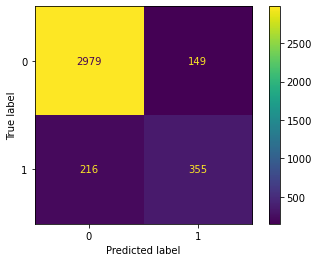

In [53]:
# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf.classes_)
disp.plot();

## Classifier Comparison

In [33]:
# custom function for model comparison results when using gridsearch to identify high-performing models
def model_comp_results(model_input):
    # Get results from model comparison
    results = pd.DataFrame(model_input.cv_results_, columns=['param_classifier','mean_test_score'])
    
    # Round results and sort in descending order
    results['mean_test_score'] = round(results['mean_test_score'], 3)
    results = results.sort_values(by='mean_test_score', ascending=False)
    return results

In [34]:
# tools
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

In [35]:
# Reduce model leakage by re-defining input and target features
X = df.drop(columns=['revenue'])
y = df.revenue

# split input/target into train/test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1424)

In [36]:
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB, CategoricalNB,  ComplementNB, GaussianNB, MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, RidgeClassifierCV, SGDClassifier, SGDOneClassSVM

In [37]:
# Gridsearch setup

# instantiate model with pipeline steps
model_holder = Pipeline([('preprocessor', preprocessor), # defined previously
                        ('classifier', RandomForestClassifier(random_state=1424))
                        ])

model_search = [{'classifier': [AdaBoostClassifier()]},
                {'classifier': [BaggingClassifier()]},
                {'classifier': [ExtraTreesClassifier()]},
                {'classifier': [GradientBoostingClassifier()]},
                {'classifier': [RandomForestClassifier()]},
                {'classifier': [HistGradientBoostingClassifier()]},
                {'classifier': [BernoulliNB()]},
                {'classifier': [CategoricalNB()]},
                {'classifier': [ComplementNB()]},
                {'classifier': [GaussianNB()]},
                {'classifier': [MultinomialNB()]},
                {'classifier': [CalibratedClassifierCV()]},
                {'classifier': [DecisionTreeClassifier()]},
                {'classifier': [ExtraTreeClassifier()]},
                {'classifier': [GaussianProcessClassifier()]},
                {'classifier': [KNeighborsClassifier()]},
                {'classifier': [MLPClassifier()]},
                {'classifier': [LinearSVC()]},
                {'classifier': [NuSVC()]},
                {'classifier': [SVC()]},
                {'classifier': [LogisticRegression()]},
                {'classifier': [LogisticRegressionCV()]},
                {'classifier': [PassiveAggressiveClassifier()]},
                {'classifier': [Perceptron()]},
                {'classifier': [RidgeClassifier()]},
                {'classifier': [RidgeClassifierCV()]},
                {'classifier': [SGDClassifier()]},
                {'classifier': [SGDOneClassSVM()]}
                ]

In [38]:
# setup stratified k-folds for gridsearch
kfold = model_selection.StratifiedKFold(n_splits=10, random_state=79, shuffle=True)

# configure gridsearch parameters
model_compare = GridSearchCV(model_holder, model_search, cv=kfold, n_jobs=-1, scoring='roc_auc')

# Fit comparison model on training data
model_compare = model_compare.fit(X_train, y_train)

d:\Data_Science\Environments_Software\Languages\Python\Miniconda3\envs\ds_core\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
70 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Data_Science\Environments_Software\Languages\Python\Miniconda3\envs\ds_core\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Data_Science\Environments_Software\Languages\Python\Miniconda3\envs\ds_core\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_st

In [39]:
model_comp_results(model_compare)

,param_classifier,mean_test_score
3,GradientBoostingClassifier(),0.929
4,RandomForestClassifier(),0.921
0,AdaBoostClassifier(),0.912
11,CalibratedClassifierCV(),0.899
17,LinearSVC(),0.898
25,RidgeClassifierCV(),0.897
1,BaggingClassifier(),0.897
24,RidgeClassifier(),0.896
2,ExtraTreesClassifier(),0.892
20,LogisticRegression(),0.891


In [40]:
# Get all classification models
from sklearn.utils import all_estimators

# create object holding all classifiers
estimators = all_estimators(type_filter='classifier')

# split object into pieces
classifier = [tup[0] for tup in estimators]
class_type = [tup[1] for tup in estimators]

# create dataframe with 2 columns from pieces
classification_models = pd.DataFrame(data=zip(classifier, class_type))

# rename dataframe coluns
classification_models = classification_models.rename(columns={0:'classifier', 1:'metadata'})

# force to string to enable str.split
classification_models.metadata = classification_models.metadata.astype('string')

# split on '.' and extract only index [1]
classification_models['family'] = classification_models['metadata'].str.split('.', expand=True)[1]

In [41]:
# select sklearn family and classifier
classification_models[['family','classifier']].sort_values(by='family')

,family,classifier
3,calibration,CalibratedClassifierCV
32,discriminant_analysis,QuadraticDiscriminantAnalysis
18,discriminant_analysis,LinearDiscriminantAnalysis
8,dummy,DummyClassifier
0,ensemble,AdaBoostClassifier
34,ensemble,RandomForestClassifier
39,ensemble,StackingClassifier
14,ensemble,HistGradientBoostingClassifier
13,ensemble,GradientBoostingClassifier
10,ensemble,ExtraTreesClassifier
